In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Rutas importantes
dataset_path = '/content/dataset/dataset'
models_path = '/content/drive/MyDrive/TFM/models'
img_type = 'img'
model_name = f'2Img_{img_type}'


Mounted at /content/drive


In [2]:
rm -rf "/content/dataset"


In [3]:
!unzip "/content/drive/MyDrive/TFM/dataset.zip" -d "/content/dataset" > /dev/null 2>&1

In [4]:
# Ruta al dataset
data_dir= f'{dataset_path}/imagenes'

img_height, img_width = 20, 20

# Listar y cargar imágenes
image_array = []
y = []

def numeric_sort_key(filename,label):
    return int(os.path.splitext(filename)[0].replace(f"_{label}",""))  # Extrae el número del nombre antes del '.jpg'

for label in ["estrellas","galaxias"]:

    data_dir_label = data_dir + "/" + label

    file_names = sorted(os.listdir(data_dir_label), key= lambda x: numeric_sort_key(x,label))
    print(len(file_names))

    for fname in file_names:

        if fname.endswith(('.png', '.jpg', '.jpeg')):

          img_path = os.path.join(data_dir_label, fname)
          img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
          img_array = tf.keras.utils.img_to_array(img)
          image_array.append(img_array)
          if label == "estrellas":
            y.append(0)
          else:
            y.append(1)

# Convertir a array de NumPy
X_images = np.array(image_array, dtype="float32") / 255.0
y = np.array(y)

10000
10000


In [5]:
# Generar una permutación aleatoria
np.random.seed(15)
perm = np.random.permutation(len(y))

# Aplicar la misma permutación a ambos arrays
X_images_shuffled = X_images[perm]
y_shuffled = y[perm]

train_per = int(round(len(y)*0.7))
valid_per = int(round(len(y)*0.15))
test_per = int(round(len(y)*0.15))

X_train, y_train = X_images_shuffled[:train_per], y_shuffled[:train_per]
X_valid, y_valid = X_images_shuffled[train_per:train_per + valid_per], y_shuffled[train_per:train_per + valid_per]
X_test, y_test = X_images_shuffled[train_per + valid_per:], y_shuffled[train_per + valid_per:]

In [6]:
from tensorflow.keras import layers, models, Input
from keras import regularizers, saving
from tensorflow.keras.optimizers import SGD, Nadam, Adam, AdamW, RMSprop
import tensorflow as tf


def convolutional_attention_block(input_tensor):
    """Atención espacial usando operaciones convolucionales"""

    # Asume que input_tensor tiene shape (None, H, W, C)
    @saving.register_keras_serializable()
    def channel_avg(x):
        return tf.reduce_mean(x, axis=3, keepdims=True)

    @saving.register_keras_serializable()
    def channel_max(x):
        return tf.reduce_max(x, axis=3, keepdims=True)

    @saving.register_keras_serializable()
    def output_shape(input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], 1)

    avg_pool = layers.Lambda(channel_avg, output_shape=output_shape)(input_tensor)
    max_pool = layers.Lambda(channel_max, output_shape=output_shape)(input_tensor)

    # Concatenar y aplicar convolución
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    attention = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(concat)

    return layers.Multiply()([input_tensor, attention])

# Entrada 1: imágenes RGB
image_input = Input(shape=(img_height, img_width, 3), name='image_input')

# Data Augmentation
x = layers.RandomRotation(0.2)(image_input)
x = layers.RandomZoom(0.2,0.2)(x)
x = layers.RandomContrast(0.2)(x)
x = layers.RandomTranslation(0.2, 0.2)(x)


# Bloque 1 con atención
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = convolutional_attention_block(x)  # Atención aquí
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = convolutional_attention_block(x)  # Atención aquí
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = convolutional_attention_block(x)  # Atención aquí
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

# Red densa final
z = layers.Dense(500, activation='relu')(x)
z = layers.Dropout(0.4)(z)
z = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.L2(1e-4))(z)
z = layers.Dropout(0.5)(z)
z = layers.Dense(500, activation='relu', kernel_regularizer=regularizers.L2(1e-4))(z)
z = layers.Dropout(0.4)(z)
output = layers.Dense(1, activation='sigmoid')(z)

# Modelo completo
model = models.Model(inputs=image_input, outputs=output)

# Compilar
# optimizer = SGD(learning_rate=0.01, momentum=0.9)
# optimizer = Nadam()
optimizer = Adam(learning_rate=1e-5)
# optimizer = RMSprop(learning_rate=1e-5, rho=0.9, momentum=0.9)
# optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 20, 20, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 20, 20, 3) │          0 │ image_input[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 20, 20, 3) │          0 │ random_rotation[… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 20, 20, 3) │          0 │ random_zoom[0][0] │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation  │ (None, 20, 20, 3) │          0 │ random_contrast[… │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 20, 20,    │        896 │ random_translati… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 20, 20, 1) │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 20, 20, 1) │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20, 20, 2) │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 20, 20, 1) │         19 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 20, 20,    │          0 │ conv2d[0][0],     │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 20, 20,    │     18,496 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 20,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 10, 10, 1) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 10, 10, 1) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10, 10, 2) │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,793,342 (6.84 MB)

 Trainable params: 1,792,574 (6.84 MB)

 Non-trainable params: 768 (3.00 KB)

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',      # Métrica a monitorear (puede ser 'val_accuracy', 'val_auc', etc.)
    patience=10,              # Número de epochs sin mejora antes de detener
    restore_best_weights=True,  # Restaura los pesos del mejor epoch
    verbose=1                # Muestra un mensaje cuando se detiene
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_valid, y_valid), callbacks=[lr_scheduler,early_stopping])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Imágenes Originales')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entto', 'Val'], loc='upper left')
plt.show()

model.save(f"{models_path}/{model_name}.keras")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8098 - auc: 0.9002 - loss: 0.5431
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

   Estrellas       0.85      0.76      0.80      1527
    Galaxias       0.77      0.86      0.82      1473

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



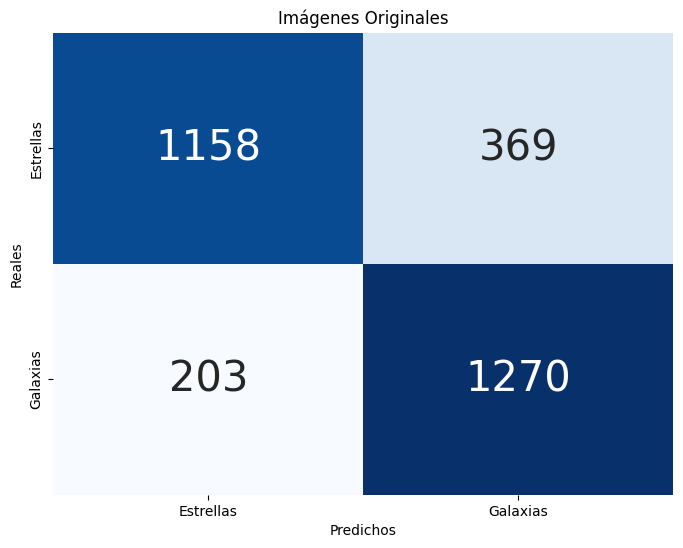

[17515  6802 11536 12700  2655  2745 11084  2633   763 16056  1031 12021
  8472  4317  1908 15629 17453 12857 11486 10088]
Index([4, 9, 17, 28, 29, 31, 39, 49, 71, 73, 75, 79, 80, 85, 86, 88, 92, 103,
       109, 112],
      dtype='int64')


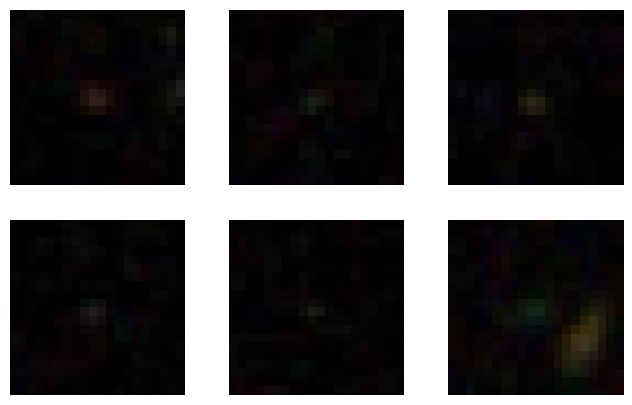

In [24]:
from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable

@register_keras_serializable()
def channel_avg(x):
    return tf.reduce_mean(x, axis=3, keepdims=True)

@register_keras_serializable()
def channel_max(x):
    return tf.reduce_max(x, axis=3, keepdims=True)

@register_keras_serializable()
def output_shape(input_shape):
    return (input_shape[0], input_shape[1], input_shape[2], 1)

model = load_model(
    f"{models_path}/{model_name}.keras",
    custom_objects={
        "channel_avg": channel_avg,
        "channel_max": channel_max,
        "output_shape": output_shape
    }
)

model.evaluate(X_test, y_test)

# Predicciones del modelo:
y_pred_probs = model.predict(X_test)
y_pred_labels = list(map(lambda x: 0 if x <= 0.5 else 1, y_pred_probs))

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_labels, target_names=["Estrellas","Galaxias"]))

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Estrellas","Galaxias"], yticklabels=["Estrellas","Galaxias"], cmap='Blues', cbar=False, annot_kws={'size': 30})
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.title('Imágenes Originales')
plt.show()

df_pred = pd.DataFrame()
df_pred["y_true"] = y_test
df_pred["y_pred"] = y_pred_labels

df_wrong = df_pred[df_pred["y_true"] != df_pred["y_pred"]]
df_well = df_pred[df_pred["y_true"] == df_pred["y_pred"]]

imgs_wrong = X_test[df_wrong.index]



[17515  6802 11536 12700  2655  2745 11084  2633   763 16056  1031 12021
  8472  4317  1908 15629 17453 12857 11486 10088]
Index([4, 9, 17, 28, 29, 31, 39, 49, 71, 73, 75, 79, 80, 85, 86, 88, 92, 103,
       109, 112],
      dtype='int64')


Text(0.515, 0.48, 'Galaxias')

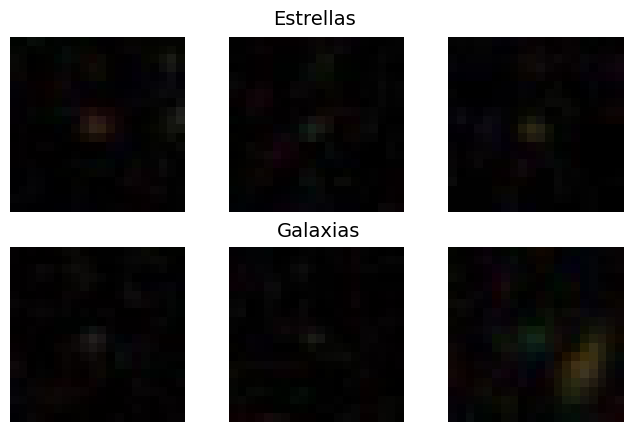

In [36]:
print(perm[train_per + valid_per:train_per + valid_per + 20])
print(df_wrong.index[:20])

chosen_imgs = imgs_wrong[[9,29,31,4,17,28]]

# Crear figura y ejes
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Iterar y mostrar cada imagen
for i, ax in enumerate(axs.flat):
    ax.imshow(chosen_imgs[i])
    # ax.set_title(f'Imagen {i+1}')
    ax.axis('off')  # Ocultar ejes

# Añadir título a la primera fila (fila 0)
fig.text(0.51, 0.905, 'Estrellas', ha='center', fontsize=14)

# Añadir título a la segunda fila (fila 1)
fig.text(0.515, 0.48, 'Galaxias', ha='center', fontsize=14)

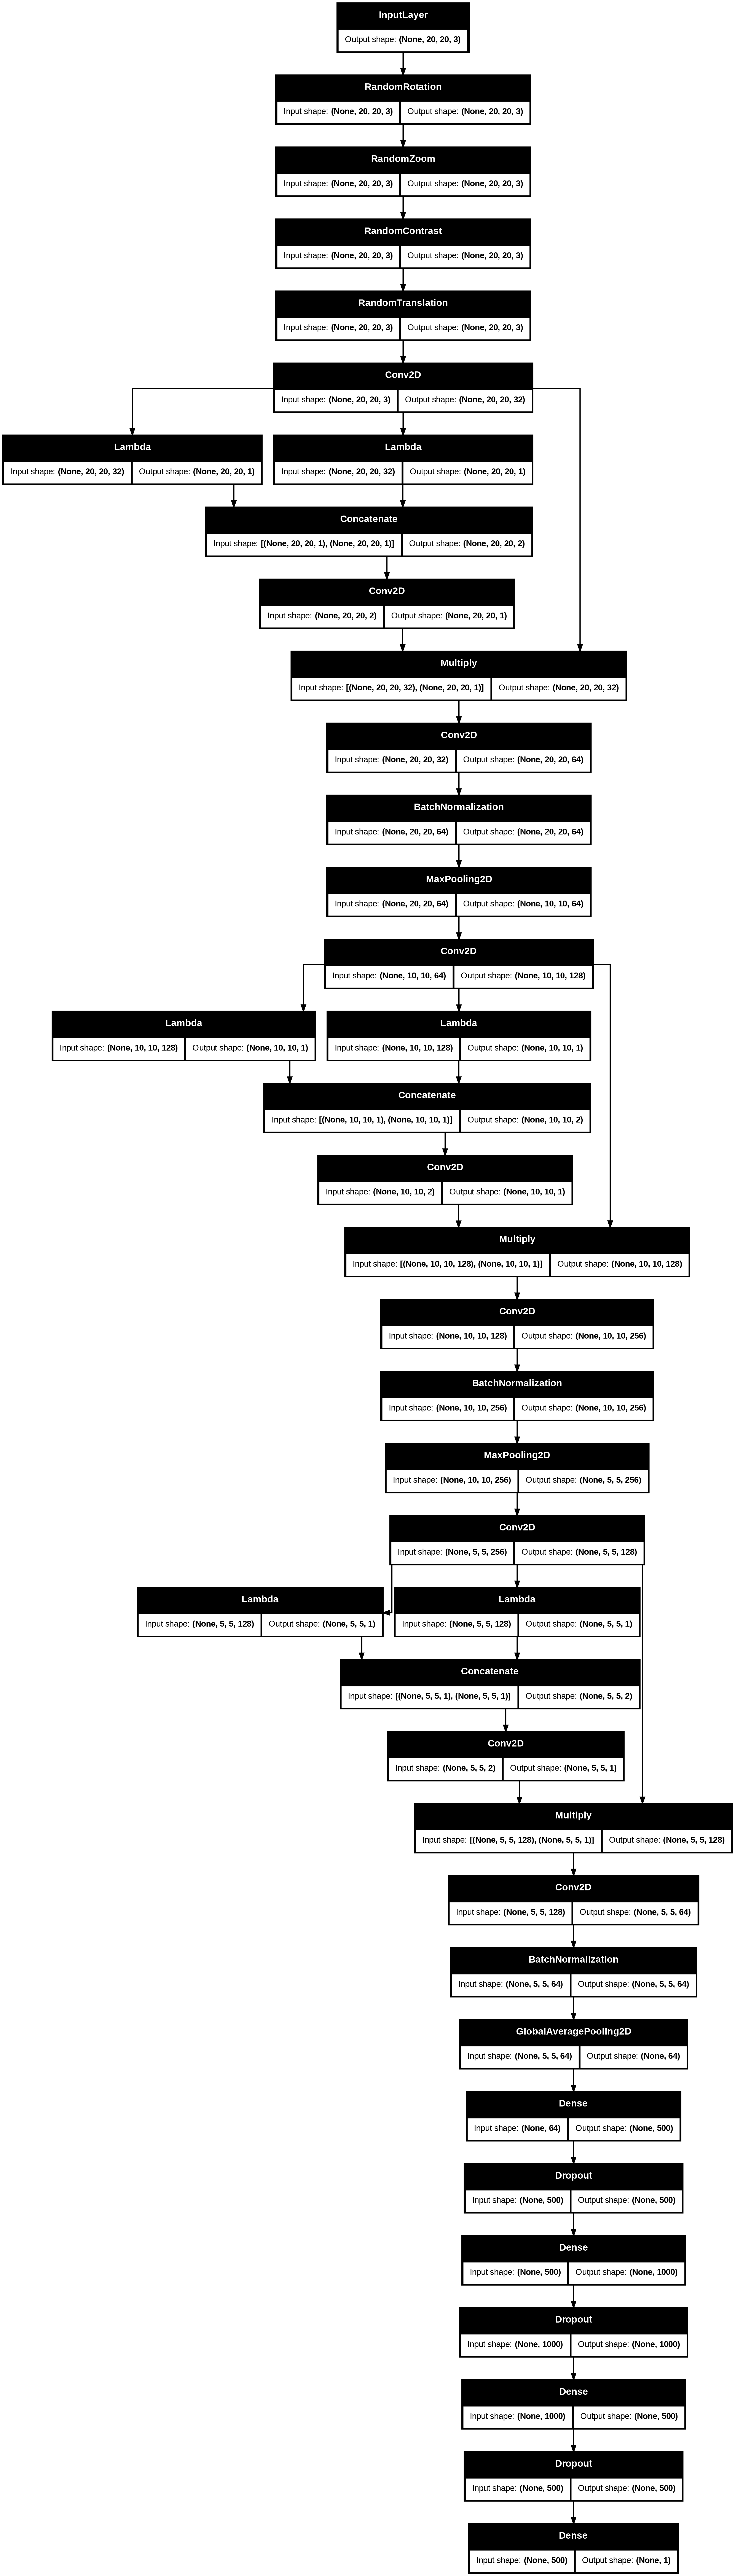

In [9]:

from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable
from keras.utils import plot_model

@register_keras_serializable()
def channel_avg(x):
    return tf.reduce_mean(x, axis=3, keepdims=True)

@register_keras_serializable()
def channel_max(x):
    return tf.reduce_max(x, axis=3, keepdims=True)

@register_keras_serializable()
def output_shape(input_shape):
    return (input_shape[0], input_shape[1], input_shape[2], 1)

model = load_model(
    f"{models_path}/{model_name}.keras",
    custom_objects={
        "channel_avg": channel_avg,
        "channel_max": channel_max,
        "output_shape": output_shape
    }
)

dot_img_file = f'{models_path}/{model_name}.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)
